In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv
import time
import matplotlib.pyplot as plt

class Mydataset(Dataset):
    
    def __init__(self, x, y=None):
        self.x = torch.FloatTensor(x)
        self.y = y
        if y is not None:
            self.y = torch.FloatTensor(y)
    
    def __getitem__(self, index):
        if self.y is None:
            return self.x[index]
        else:
            return self.x[index], self.y[index]
  
    def __len__(self):
        return len(self.x)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )
  
    def forward(self, x):
        return self.net(x).squeeze(1)

def test(x, model):
    test_set = Mydataset(x)
    test_loader = DataLoader(test_set, shuffle=False)
    model.eval()
    ans = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data.cuda())
            for pred in test_pred:
                ans.append(float(pred.cpu().data.numpy()))
    return ans

In [2]:
dfg = pd.read_csv("LBMA-GOLD.csv")
dfb = pd.read_csv("BCHAIN-MKPRU.csv")

df = dfb
df["Gold"] = np.nan
tot = len(dfb)
p = len(dfg) - 1
pre = -1
for i in range(tot - 1, -1, -1):
    sl = dfb.iloc[i, 0]
    if (sl[0] == "2" and sl[1] == "0"):
        sl = sl[2:]
    if (sl[0] == "0"):
        sl = sl[1:]
        
    if (sl == dfg.iloc[p, 0]):
        df.iloc[i, 2] = dfg.iloc[p, 1]
        p -= 1
        
    if (np.isnan(df.iloc[i, 2])):
        df.iloc[i, 2] = df.iloc[i + 1, 2]     
    df.iloc[i, 0] = sl

#0是比特币 1是黄金
x = df.iloc[:, 1:3].values
model_b = torch.load("Bitcoin_model.pkl")
model_g = torch.load("Gold_model.pkl")
x

array([[  621.65,  1324.6 ],
       [  609.67,  1324.6 ],
       [  610.92,  1323.65],
       ...,
       [46809.17,  1786.  ],
       [46078.38,  1788.25],
       [46368.69,  1794.6 ]])

In [3]:
windows = 5
n = len(x)
data_b = np.zeros((n - windows, windows), dtype=float)
data_g = np.zeros((n - windows, windows), dtype=float)
for i in range(n - windows):
    data_b[i, :] = x[i: i + windows, 0]
    data_g[i, :] = x[i: i + windows, 1]
    
x0 = data_b
x1 = data_g
x0 = (x0 - x0.min()) / (x0.max() - x0.min())
x1 = (x1 - x1.min()) / (x1.max() - x1.min())

y0 = test(x0, model_b)
y1 = test(x1, model_g)


In [4]:
y0 = np.array(y0).reshape(-1, 1)
y1 = np.array(y1).reshape(-1, 1)
y = np.concatenate([y0, y1], axis = 1)
y

array([[  915.7064209 ,  1278.85205078],
       [  915.67602539,  1273.94372559],
       [  913.60168457,  1294.41040039],
       ...,
       [47889.4375    ,  1717.72155762],
       [42852.66015625,  1683.76782227],
       [41952.6171875 ,  1720.8104248 ]])

In [5]:
dfg = pd.read_csv("LBMA-GOLD.csv")
dfb = pd.read_csv("BCHAIN-MKPRU.csv")

df = dfb
df["Gold"] = np.nan
tot = len(dfb)
p = len(dfg) - 1
pre = -1
shinan = np.zeros(2000)
for i in range(tot - 1, -1, -1):
    sl = dfb.iloc[i, 0]
    if (sl[0] == "2" and sl[1] == "0"):
        sl = sl[2:]
    if (sl[0] == "0"):
        sl = sl[1:]
        
    if (sl == dfg.iloc[p, 0]):
        df.iloc[i, 2] = dfg.iloc[p, 1]
        p -= 1
        
    if (np.isnan(df.iloc[i, 2])):
        shinan[i] = 1
        df.iloc[i, 2] = df.iloc[i + 1, 2]     
    df.iloc[i, 0] = sl

In [45]:


#0是比特币 1是黄金
x = df.iloc[:, 1:3].values

jg = x
bl = np.zeros((tot, 2))
lr = np.zeros((tot, 2))
cq = np.zeros((tot, 2))
dq = np.zeros((tot, 2))
for i in range(1, tot):
    bl[i, 0] = x[i, 0] / x[i - 1 , 0]
    bl[i, 1] = x[i, 1] / x[i - 1, 1] 
bl[0, 0] = 1
bl[0, 1] = 1
x = bl
win_short = 12
win_long = 5
alfb = 0.04
alfg = 0.02

bb = 0.007
bg = 0.0042


money = 1000
bit = 0
gold = 0
money_lis1 = []
bit_lis1 = []
gold_lis1 = []
for i in range(len(y0)):
    c = i + 5
    dq[i] = np.mean(x[max(0, c - win_short): c, :], axis = 0)
    cq[i] = np.mean(x[max(0, c - win_long): c, :], axis = 0)
    
    lr[i] = cq[i] / dq[i]
    rate = cq[i] / dq[i]
    if money > 0:
        if (rate[0] > 1 + bb+ alfb/2.5 and rate[1] > 1 + bg ):
            if rate[0] > rate[1] and money * alfb < y[i, 0] * (1 + bb) - money:
                bit += money * (1 - alfb) / jg[i, 0]
                money = 0
            elif money * alfb < y[i, 1] * (1 + bg) - money and shinan[i] == 0:
                gold += money * (1 - alfg) / jg[i, 1]
                money = 0
        elif rate[0] > 1 + bb+ alfb/2.5:
            bit += money * (1 - alfb) / jg[i, 0]
            money = 0
        elif rate[1] > 1 + bg and shinan[i] == 0:
            gold += money * (1 - alfg) / jg[i, 1]
            money = 0
        
        if money == 0:
            print("day ", i ,": ", money, bit, gold, "danjia:", jg[i, 0], jg[i, 1])
        
    
    if (rate[0] < 0.983 and bit > 0):
        money += bit * jg[i, 0] * (1-alfb)
        bit = 0
        print("day ", i ,": ", money, bit, gold, "danjia:", jg[i, 0], jg[i, 1])
        
    if (rate[1] < 0.997 and shinan[i] == 0 and gold > 0):
        money += gold * jg[i, 1] * (1-alfg)
        gold = 0
        print("day ", i ,": ", money, bit, gold, "danjia:", jg[i, 0], jg[i, 1])
    
    
    money_lis1.append(money)
    bit_lis1.append(bit)
    gold_lis1.append(gold)




day  64 :  0 0 0.8075148319050759 danjia: 706.46 1213.6
day  134 :  959.8064765985498 0 0 danjia: 922.0736125 1212.85
day  142 :  0 0 0.7755692175680894 danjia: 964.706075 1212.8
day  151 :  940.0395281224486 0 0 danjia: 976.103 1236.8
day  183 :  0 0 0.7650213731606041 danjia: 1227.68 1204.2
day  269 :  967.8897408953331 0 0 danjia: 2664.920863 1291.0
day  308 :  0 0.481134668099506 0 danjia: 1931.2143 1234.1
day  314 :  1296.8048992325726 0 0 danjia: 2807.609857 1255.55
day  369 :  0 0.3870541884210972 0 danjia: 3216.43 1322.85
day  398 :  2132.6148487621685 0 0 danjia: 5739.438733 1303.3
day  427 :  0 0.35815294646109674 0 danjia: 5716.301583 1277.95
day  435 :  2767.709698739347 0 0 danjia: 8049.72 1286.2
day  448 :  0 0.23445600769087446 0 danjia: 11332.622 1273.45
day  453 :  3795.009226516715 0 0 danjia: 16860.88 1250.65
day  469 :  0 0.26117737123923435 0 danjia: 13949.175 1279.4
day  482 :  4342.447301387333 0 0 danjia: 17319.198 1319.95
day  494 :  0 0.36743885953630956 0 dan

In [101]:


#0是比特币 1是黄金
x = df.iloc[:, 1:3].values

jg = x
bl = np.zeros((tot, 2))
lr = np.zeros((tot, 2))
cq = np.zeros((tot, 2))
dq = np.zeros((tot, 2))
for i in range(1, tot):
    bl[i, 0] = x[i, 0] / x[i - 1 , 0]
    bl[i, 1] = x[i, 1] / x[i - 1, 1] 
bl[0, 0] = 1
bl[0, 1] = 1
x = bl
win_short = 12
win_long = 5
alfb = 0.03
alfg = 0.015

bb = 0.0075
bg = 0.004


money = 1000
bit = 0
gold = 0
money_lis2 = []
bit_lis2 = []
gold_lis2 = []
for i in range(len(y0)):
    c = i + 5
    dq[i] = np.mean(x[max(0, c - win_short): c, :], axis = 0)
    cq[i] = np.mean(x[max(0, c - win_long): c, :], axis = 0)
    
    lr[i] = cq[i] / dq[i]
    rate = cq[i] / dq[i]
    if money > 0:
        if (rate[0] > 1 + bb and rate[1] > 1 + bg):
            if rate[0] > rate[1] and money * alfb < y[i, 0] * (1 + bb) - money:
                bit += money * (1 - alfb) / jg[i, 0]
                money = 0
            elif money * alfb < y[i, 1] * (1 + bg) - money and shinan[i] == 0:
                gold += money * (1 - alfg) / jg[i, 1]
                money = 0
        elif rate[0] > 1 + bb:
            bit += money * (1 - alfb) / jg[i, 0]
            money = 0
        elif rate[1] > 1 + bg and shinan[i] == 0:
            gold += money * (1 - alfg) / jg[i, 1]
            money = 0
        
        if money == 0:
            print("day ", i ,": ", money, bit, gold, "danjia:", jg[i, 0], jg[i, 1])
        
    
    if (rate[0] < 0.991 and bit > 0):
        money += bit * jg[i, 0] * (1-alfb)
        bit = 0
        print("day ", i ,": ", money, bit, gold, "danjia:", jg[i, 0], jg[i, 1])
        
    if (rate[1] < 0.997 and shinan[i] == 0 and gold > 0):
        money += gold * jg[i, 1] * (1-alfg)
        gold = 0
        print("day ", i ,": ", money, bit, gold, "danjia:", jg[i, 0], jg[i, 1])
    
    
    money_lis2.append(money)
    bit_lis2.append(bit)
    gold_lis2.append(gold)

print("finnal:",  "danjia:", jg[i, 0], jg[i, 1])
print(money + bit * jg[-1,0] * (1-alfb) + gold * jg[-1,1] * (1-alfg))


day  26 :  0 0 0.7825223435948362 danjia: 617.21 1258.75
day  53 :  1002.7906454816286 0 0 danjia: 686.17 1301.0
day  64 :  0 1.3768747361735691 0 danjia: 706.46 1213.6
day  114 :  1353.4918232790278 0 0 danjia: 1013.42 1151.0
day  123 :  0 1.6812055890240447 0 danjia: 780.92 1205.05
day  130 :  1460.841413032708 0 0 danjia: 895.798875 1196.05
day  141 :  0 1.5534221715231769 0 danjia: 912.19 1192.8
day  147 :  1558.156846959762 0 0 danjia: 1034.07 1226.75
day  156 :  0 1.509600620806002 0 danjia: 1001.2 1230.75
day  167 :  1684.846447152613 0 0 danjia: 1150.605714 1257.2
day  179 :  0 1.3705185273192722 0 danjia: 1192.469143 1206.55
day  183 :  1632.0814400507443 0 0 danjia: 1227.68 1204.2
day  184 :  0 0 1.3345510696081546 danjia: 1245.370786 1204.6
day  269 :  1697.0618494011655 0 0 danjia: 2664.920863 1291.0
day  278 :  0 0.6678202153924164 0 danjia: 2464.959814 1255.4
day  285 :  1757.7532941211236 0 0 danjia: 2713.48 1255.7
day  293 :  0 0.6816834306056888 0 danjia: 2501.191343 1

day  1415 :  65030.841082871644 0 0 danjia: 9938.83 1936.65
day  1416 :  0 5.712518641815683 0 danjia: 11042.4 1940.9
day  1418 :  61521.48306845989 0 0 danjia: 11102.67 1957.65
day  1423 :  0 0 30.637878973877843 danjia: 11242.57 1977.9
day  1425 :  62383.09514803881 0 0 danjia: 11750.28 2067.15
day  1432 :  0 0 31.6046540932587 danjia: 11573.11 1944.25
day  1438 :  61669.6874623643 0 0 danjia: 11969.53 1981.0
day  1445 :  0 0 31.425873483757385 danjia: 11337.4 1932.95
day  1451 :  61053.079242203545 0 0 danjia: 11659.57 1972.35
day  1457 :  0 5.774928435877908 0 danjia: 10254.93 1928.45
day  1468 :  61304.17611331628 0 0 danjia: 10943.89 1950.85
day  1478 :  0 0 32.38996592373359 danjia: 10774.24 1864.3
day  1516 :  61844.53450318846 0 0 danjia: 14155.59 1938.45
day  1528 :  0 3.5867659463797215 0 danjia: 16725.15 1889.05
day  1533 :  65059.477710639774 0 0 danjia: 18699.75 1840.2
day  1542 :  0 0 35.390631254993885 danjia: 19709.73 1810.75
day  1548 :  64837.432533684994 0 0 danjia:

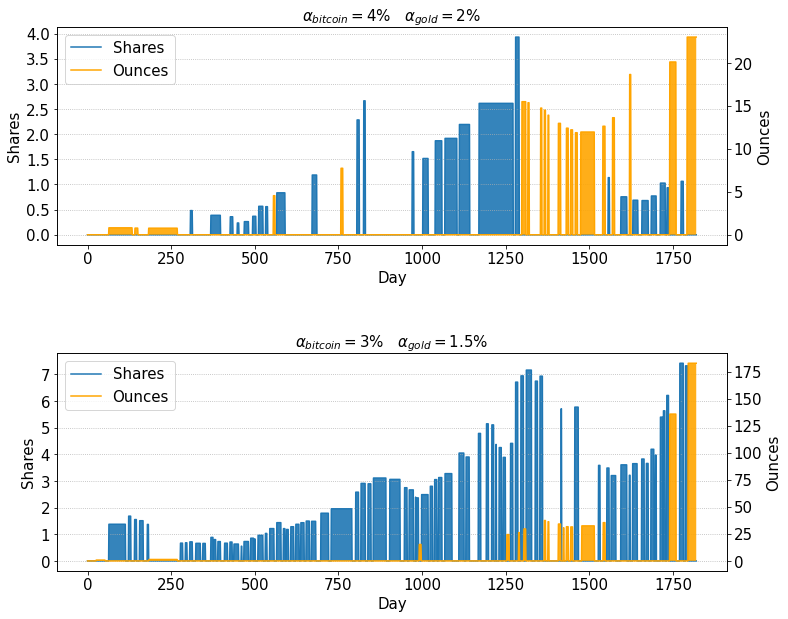

In [102]:
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
ax1 = fig.add_subplot(211)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax2 = ax1.twinx()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
p1 = ax1.plot(bit_lis1, label="Shares")

p2 = ax2.plot(gold_lis1, label="Ounces", color="orange")

lns = p1 + p2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=15, loc = 2)

ax1.set_title(r"$\alpha_{bitcoin}=4$%   $\alpha_{gold}=2$%", fontsize=15)
ax1.set_ylabel('Shares', fontsize=15)
ax2.set_ylabel('Ounces', fontsize=15)
ax1.set_xlabel('Day', fontsize=15)

xzb = list(range(len(bit_lis)))
ax1.fill_between(xzb, bit_lis ,0 #, facecolor = 'limegreen'
                 , alpha = 0.9, interpolate=True)
ax2.fill_between(xzb, gold_lis ,0 , facecolor = 'orange'
                 , alpha = 0.9, interpolate=True)
ax1.grid(b=True, axis="y", ls=':')




# plt.savefig("bit43_gold21-5.png")

ax3 = fig.add_subplot(212)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax4 = ax3.twinx()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
p1 = ax3.plot(bit_lis2, label="Shares")

p2 = ax4.plot(gold_lis2, label="Ounces", color="orange")

lns = p1 + p2
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, fontsize=15, loc = 2)

ax3.set_title(r"$\alpha_{bitcoin}=3$%   $\alpha_{gold}=1.5$%", fontsize=15)
ax3.set_ylabel('Shares', fontsize=15)
ax4.set_ylabel('Ounces', fontsize=15)
ax3.set_xlabel('Day', fontsize=15)

xzb = list(range(len(bit_lis)))
ax3.fill_between(xzb, bit_lis2 ,0 #, facecolor = 'limegreen'
                 , alpha = 0.9, interpolate=True)
ax4.fill_between(xzb, gold_lis2 ,0 , facecolor = 'orange'
                 , alpha = 0.9, interpolate=True)
ax3.grid(b=True, axis="y", ls=':')

plt.savefig("celue.png")
plt.show()